# Determining the Cost of Cars

A used car sales service, "Not damaged, not painted," is developing an application to attract new customers. In it, you can quickly find out the market value of your car. You have historical data at your disposal: technical specifications, configurations, and prices of cars. You need to build a model to determine the cost.

The customer values:

- prediction quality;
- prediction speed;
- training time.

# Research Procedure

1. Load the data from the file path: /datasets/autos.csv.
2. Examine the data. Fill in missing values and handle anomalies in columns if any. Remove uninformative features among the characteristics.
3. Prepare datasets for model training.
4. Train different models, including at least one LightGBM and one non-boosting model. Try different hyperparameters for each model.
5. Analyze training time, prediction time, and model quality for each model.
6. Based on customer criteria, select the best model, and verify its quality on the test dataset.

Data Description

Features:

- DateCrawled — date of crawling the listing from the database

- VehicleType — type of car body

- RegistrationYear — year of car registration

- Gearbox — type of transmission

- Power — power (hp)

- Model — car model

- Kilometer — mileage (km)

- RegistrationMonth — month of car registration

- FuelType — fuel type

- Brand — car brand

- Repaired — whether the car was repaired or not

- DateCreated — date of creating the listing

- NumberOfPictures — number of car pictures

- PostalCode — postal code of the listing owner (user)

- LastSeen — date of the user's last activity

Target Feature:

- Price — price (euro)

## Data Preparation

Import all the necessary libraries.

In [1]:
!pip3 install category_encoders

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import lightgbm as lgb
import time
import category_encoders as ce
import catboost

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [3]:
pth1_ar = ['/Users/daniyardjumaliev/Jupyter/Projects/datasets/autos.csv']
pth2_ar = ['backup_path1.csv']
df = None

for pth1, pth2 in zip(pth1_ar, pth2_ar):
    if os.path.exists(pth1):
        df = pd.read_csv(pth1)
    elif os.path.exists(pth2):
        df = pd.read_csv(pth2)
    else:
        print(f'Warning: File not found in both paths for {pth1} and {pth2}')
else:
    print('File loaded successfully.')

File loaded successfully.


Currently, we have only one source from which we obtain the file for the research. If alternative paths for finding the file emerge in the future, they can be added to a second array. This is done to avoid errors during the data loading stage. Alternatively, create a third, fourth, and so on, following the same analogy.

Let's check the data quality from the dataset.

In [4]:
display(df.head(10))
display(df.tail(10))
display(df.describe())
df.info()
display(f'Duplicates: {df.duplicated().sum()}')
display(f'Missing values:')
display(df.isna().sum())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354359,2016-03-28 13:48:07,7900,sedan,2010,manual,140,golf,150000,7,gasoline,volkswagen,no,2016-03-28 00:00:00,0,75223,2016-04-02 18:16:20
354360,2016-04-02 20:37:03,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,no,2016-04-02 00:00:00,0,81825,2016-04-06 20:47:12
354361,2016-03-09 13:37:43,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,no,2016-03-09 00:00:00,0,51371,2016-03-13 01:44:13
354362,2016-03-19 19:53:49,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes,2016-03-19 00:00:00,0,96465,2016-03-19 20:44:43
354363,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,0,26624,2016-03-29 10:17:23
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

'Duplicates: 4'

'Missing values:'

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

To begin with, let's remove all the columns that won't be needed during model training: DateCrawled, DateCreated, NumberOfPictures, LastSeen. The reason for this is that these features are not in any way related to the price of the car, our target variable.

In [5]:
columns_to_delete = ['DateCrawled', 'DateCreated', 'NumberOfPictures', 'LastSeen']
df.drop(columns=columns_to_delete, inplace=True)

display(df.head(10))
display(df.tail(10))

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,70435
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,66954
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,33775
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,67112
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,19348
8,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,94505
9,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,27472


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
354359,7900,sedan,2010,manual,140,golf,150000,7,gasoline,volkswagen,no,75223
354360,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,no,81825
354361,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,no,51371
354362,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes,96465
354363,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,26624
354364,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2694
354365,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,39576
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,26135
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,87439
354368,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,40764


Delete duplicates.

In [6]:
df.drop_duplicates(inplace=True)
display(f'Duplicates: {df.duplicated().sum()}')

'Duplicates: 0'

In [7]:
display(df['FuelType'].value_counts())

FuelType
petrol      203192
gasoline     91940
lpg           4954
cng            531
hybrid         228
other          200
electric        89
Name: count, dtype: int64

Let's replace all occurrences of "gasoline" with "petrol" because they refer to the same thing.

In [8]:
df['FuelType'] = df['FuelType'].replace('gasoline', 'petrol')
display(df['FuelType'].value_counts())

FuelType
petrol      295132
lpg           4954
cng            531
hybrid         228
other          200
electric        89
Name: count, dtype: int64

Next, either we'll remove the missing and anomalous values, or we'll attempt to restore them based on the available data.

In [9]:
display(df['Power'].describe())
display(df['Power'].value_counts())
display(df['Power'].median())

count    333036.000000
mean        109.753225
std         194.288179
min           0.000000
25%          68.000000
50%         103.000000
75%         140.000000
max       20000.000000
Name: Power, dtype: float64

Power
0       38664
75      22543
60      14853
150     13541
101     12495
        ...  
2789        1
519         1
2461        1
6006        1
1241        1
Name: count, Length: 712, dtype: int64

103.0

Replacing zero values with the median could significantly distort the overall picture. Since there are approximately 40,000 zero values, it was decided to replace them with random values ranging from 60 to 200 horsepower, which are the majority among all the data.

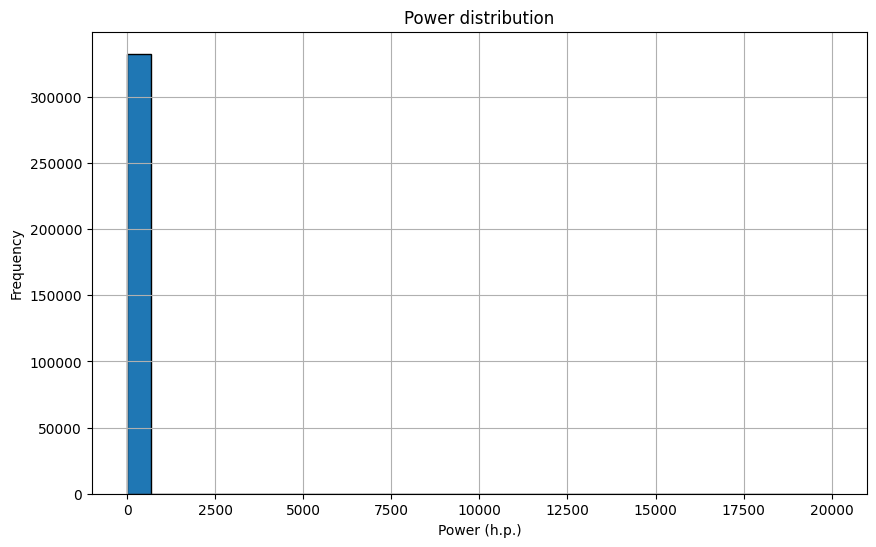

In [10]:
random_powers = np.random.randint(60, 201, size=len(df[df['Power'] == 0]))

df.loc[df['Power'] == 0, 'Power'] = random_powers

plt.figure(figsize=(10, 6))
plt.hist(df['Power'], bins=30, edgecolor='k')
plt.title('Power distribution')
plt.xlabel('Power (h.p.)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In the column with engine power, there are anomalous values exceeding 1000 horsepower, which is definitely an error in filling for production cars. Additionally, there are many zero values, which are most likely errors as well. Let's remove all values above 600 and below 30.

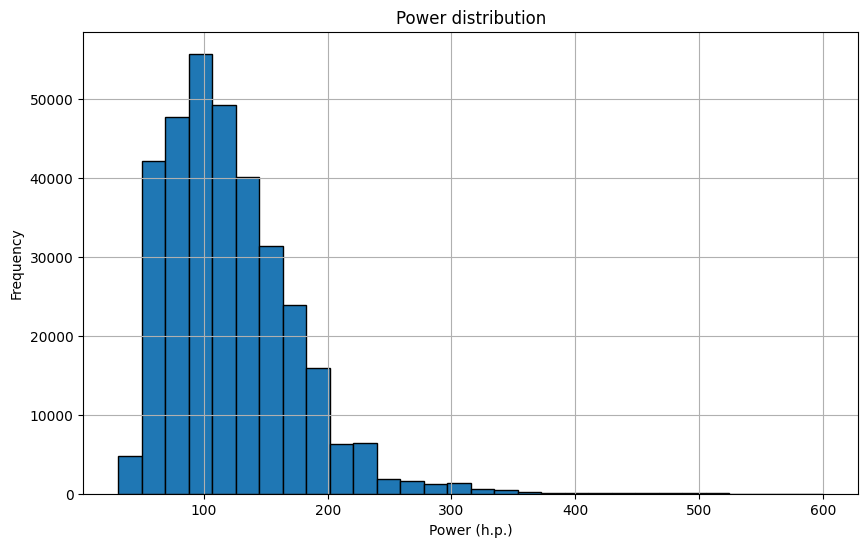

In [11]:
df = df[(df['Power'] <= 600) & (df['Power'] > 30)]
plt.figure(figsize=(10, 6))
plt.hist(df['Power'], bins=30, edgecolor='k')
plt.title('Power distribution')
plt.xlabel('Power (h.p.)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

This is how it was possible to maintain a normal distribution of data. Next, let's try to replace missing values in the columns VehicleType and Model by leveraging the relationship between these columns and the Brand column. That is, we will replace empty values in the VehicleType column similarly to the corresponding filled values in conjunction with Model and Brand. We will do the same for the Model column.

In [12]:
df['VehicleType'].fillna(df.groupby(['Model', 'Brand'])['VehicleType'].transform('first'), inplace=True)
df['Model'].fillna(df.groupby(['VehicleType', 'Brand'])['Model'].transform('first'), inplace=True)

display(f'Missing values:')
display(df.isna().sum())

'Missing values:'

Price                    0
VehicleType           6548
RegistrationYear         0
Gearbox              18900
Power                    0
Model                 8608
Kilometer                0
RegistrationMonth        0
FuelType             31676
Brand                    0
Repaired             67683
PostalCode               0
dtype: int64

Now let's remove the remaining empty values in the VehicleType and Model columns. Unfortunately, replacing values in the Gearbox and FuelType columns in a similar manner would not be entirely accurate because the transmission and fuel type can vary for the same model. For example, a diesel or petrol engine, automatic or manual transmission. This typically has a direct impact on the price. Therefore, we will simply remove these empty values.

In [13]:
df = df.dropna(subset=['VehicleType', 'Model', 'Gearbox', 'FuelType'])

display(f'Missing values:')
display(df.isna().sum())

display(df.head(10))
display(df.tail(10))

'Missing values:'

Price                    0
VehicleType              0
RegistrationYear         0
Gearbox                  0
Power                    0
Model                    0
Kilometer                0
RegistrationMonth        0
FuelType                 0
Brand                    0
Repaired             45643
PostalCode               0
dtype: int64

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
0,480,small,1993,manual,72,golf,150000,0,petrol,volkswagen,NaN,70435
1,18300,coupe,2011,manual,190,tt,125000,5,petrol,audi,yes,66954
2,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,NaN,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,7,petrol,skoda,no,60437
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,33775
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,67112
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,19348
8,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,94505
10,2000,sedan,2004,manual,105,3_reihe,150000,12,petrol,mazda,no,96224


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
354354,5000,sedan,2003,auto,260,e_klasse,150000,12,petrol,mercedes_benz,yes,90473
354356,999,convertible,2000,manual,95,megane,150000,4,petrol,renault,NaN,88477
354357,1690,wagon,2004,manual,55,fabia,150000,4,petrol,skoda,NaN,18246
354358,1490,small,1998,manual,50,lupo,150000,9,petrol,volkswagen,no,48653
354359,7900,sedan,2010,manual,140,golf,150000,7,petrol,volkswagen,no,75223
354362,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes,96465
354364,0,sedan,2005,manual,110,colt,150000,7,petrol,mitsubishi,yes,2694
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,26135
354367,9200,bus,1996,manual,102,transporter,150000,3,petrol,volkswagen,no,87439
354368,3400,wagon,2002,manual,100,golf,150000,6,petrol,volkswagen,NaN,40764


Let's fill the Repaired column with random values, either "yes" or "no."

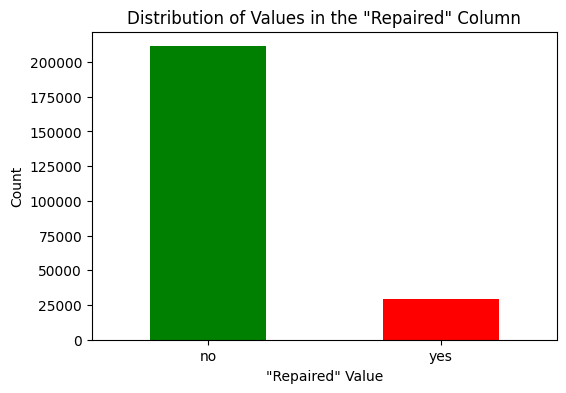

In [14]:
plt.figure(figsize=(6, 4))
df['Repaired'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Distribution of Values in the "Repaired" Column')
plt.xlabel('"Repaired" Value')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

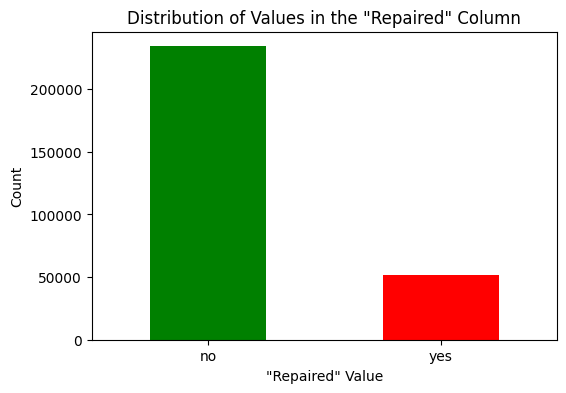

In [15]:
mask = df['Repaired'].isnull()
random_values = np.random.choice(['yes', 'no'], size=sum(mask))
df.loc[mask, 'Repaired'] = random_values

plt.figure(figsize=(6, 4))
df['Repaired'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Distribution of Values in the "Repaired" Column')
plt.xlabel('"Repaired" Value')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

After the replacement, the ratio remained approximately the same.

Let's check if all empty values have been excluded from the dataset.

In [16]:
display(f'Misiing values:')
display(df.isna().sum())

display(df.head(10))
display(df.tail(10))

'Misiing values:'

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
PostalCode           0
dtype: int64

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
0,480,small,1993,manual,72,golf,150000,0,petrol,volkswagen,no,70435
1,18300,coupe,2011,manual,190,tt,125000,5,petrol,audi,yes,66954
2,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,no,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,7,petrol,skoda,no,60437
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,33775
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,67112
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,19348
8,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,no,94505
10,2000,sedan,2004,manual,105,3_reihe,150000,12,petrol,mazda,no,96224


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
354354,5000,sedan,2003,auto,260,e_klasse,150000,12,petrol,mercedes_benz,yes,90473
354356,999,convertible,2000,manual,95,megane,150000,4,petrol,renault,no,88477
354357,1690,wagon,2004,manual,55,fabia,150000,4,petrol,skoda,yes,18246
354358,1490,small,1998,manual,50,lupo,150000,9,petrol,volkswagen,no,48653
354359,7900,sedan,2010,manual,140,golf,150000,7,petrol,volkswagen,no,75223
354362,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes,96465
354364,0,sedan,2005,manual,110,colt,150000,7,petrol,mitsubishi,yes,2694
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,26135
354367,9200,bus,1996,manual,102,transporter,150000,3,petrol,volkswagen,no,87439
354368,3400,wagon,2002,manual,100,golf,150000,6,petrol,volkswagen,no,40764


Since Gearbox and Repaired are essentially boolean values, let's replace them with 1 and 0. A manual transmission will be represented as 0, and an automatic one as 1. For Repaired, if there was a repair, it will be 1, and if not, it will be 0.

In [17]:
df['Gearbox'] = df['Gearbox'].map({'manual': 0, 'auto': 1})
df['Repaired'] = df['Repaired'].map({'no': 0, 'yes': 1})

display(df.head(10))
display(df.tail(10))

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
0,480,small,1993,0,72,golf,150000,0,petrol,volkswagen,0,70435
1,18300,coupe,2011,0,190,tt,125000,5,petrol,audi,1,66954
2,9800,suv,2004,1,163,grand,125000,8,petrol,jeep,0,90480
3,1500,small,2001,0,75,golf,150000,6,petrol,volkswagen,0,91074
4,3600,small,2008,0,69,fabia,90000,7,petrol,skoda,0,60437
5,650,sedan,1995,0,102,3er,150000,10,petrol,bmw,1,33775
6,2200,convertible,2004,0,109,2_reihe,150000,8,petrol,peugeot,0,67112
7,0,sedan,1980,0,50,other,40000,7,petrol,volkswagen,0,19348
8,14500,bus,2014,0,125,c_max,30000,8,petrol,ford,0,94505
10,2000,sedan,2004,0,105,3_reihe,150000,12,petrol,mazda,0,96224


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
354354,5000,sedan,2003,1,260,e_klasse,150000,12,petrol,mercedes_benz,1,90473
354356,999,convertible,2000,0,95,megane,150000,4,petrol,renault,0,88477
354357,1690,wagon,2004,0,55,fabia,150000,4,petrol,skoda,1,18246
354358,1490,small,1998,0,50,lupo,150000,9,petrol,volkswagen,0,48653
354359,7900,sedan,2010,0,140,golf,150000,7,petrol,volkswagen,0,75223
354362,3200,sedan,2004,0,225,leon,150000,5,petrol,seat,1,96465
354364,0,sedan,2005,0,110,colt,150000,7,petrol,mitsubishi,1,2694
354366,1199,convertible,2000,1,101,fortwo,125000,3,petrol,smart,0,26135
354367,9200,bus,1996,0,102,transporter,150000,3,petrol,volkswagen,0,87439
354368,3400,wagon,2002,0,100,golf,150000,6,petrol,volkswagen,0,40764


Now let's check the RegistrationYear column for outliers and anomalous values.

In [18]:
display(df['RegistrationYear'].value_counts())

RegistrationYear
1999    19177
2000    17845
2005    17770
2006    17274
2001    17137
        ...  
1932        1
1931        1
1927        1
1947        1
7500        1
Name: count, Length: 94, dtype: int64

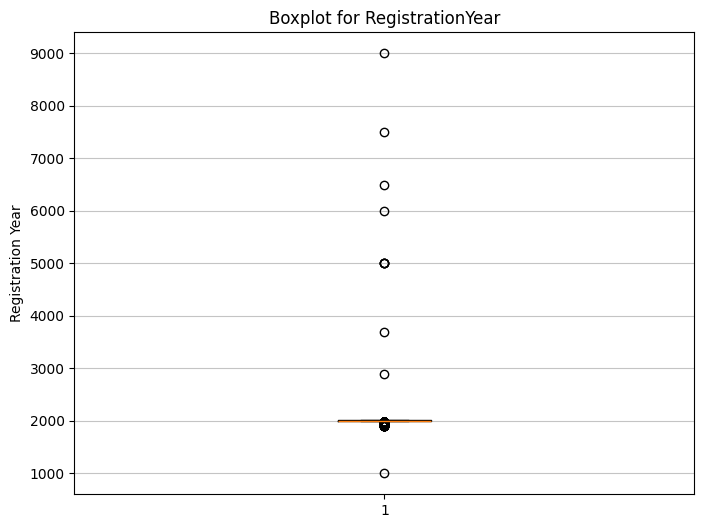

In [19]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['RegistrationYear'])
plt.title('Boxplot for RegistrationYear')
plt.ylabel('Registration Year')
plt.grid(axis='y', alpha=0.75)

plt.show()

Let's remove all the outliers.

In [20]:
df = df[(df['RegistrationYear'] >= 1920) & (df['RegistrationYear'] <= 2016)]

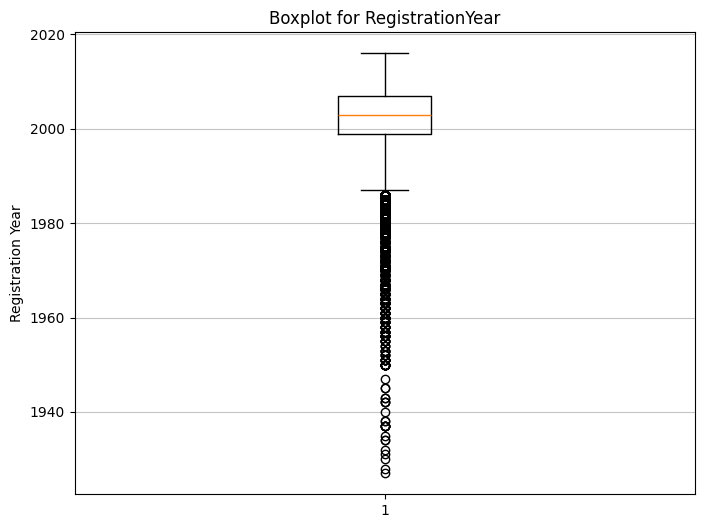

In [21]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['RegistrationYear'])
plt.title('Boxplot for RegistrationYear')
plt.ylabel('Registration Year')
plt.grid(axis='y', alpha=0.75)

plt.show()

Cars with a registration year of 1920 and beyond may be vintage or rare vehicles, so let's keep them.

In [22]:
display(df['RegistrationMonth'].value_counts())

RegistrationMonth
3     28739
6     25909
4     24433
5     24043
7     22524
10    21608
12    19936
9     19838
11    19765
1     19033
8     18659
2     17674
0     17297
Name: count, dtype: int64

As usual, let's replace all the zero values in the RegistrationMonth column with random values from 1 to 12. This should not significantly impact the training.

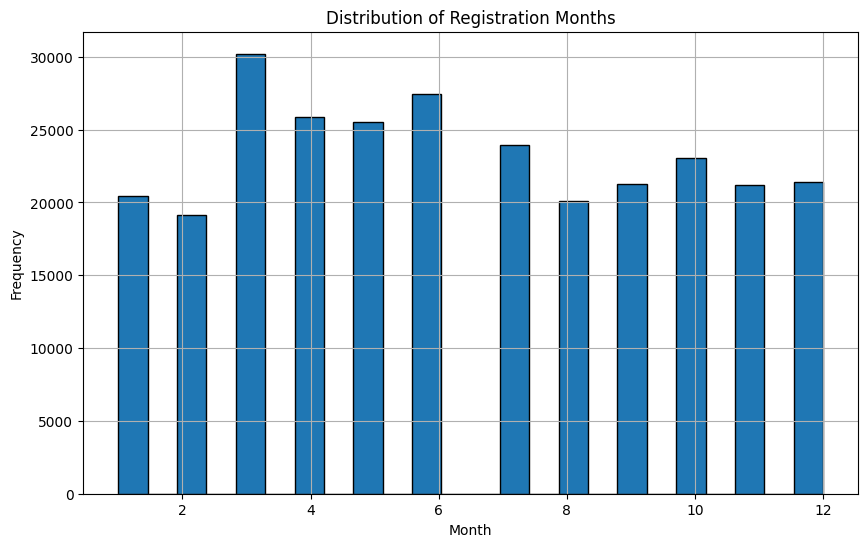

In [23]:
random_months = np.random.randint(1, 13, size=len(df[df['RegistrationMonth'] == 0]))

df.loc[df['RegistrationMonth'] == 0, 'RegistrationMonth'] = random_months

plt.figure(figsize=(10, 6))
plt.hist(df['RegistrationMonth'], bins=24, edgecolor='k')
plt.title('Distribution of Registration Months')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Let's check the correlation between features.

In [24]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
correlation_df = numeric_df.corr()

cmap = plt.get_cmap('coolwarm')
styled_corr_matrix = correlation_df.style.background_gradient(cmap=cmap, axis=None)
display(styled_corr_matrix)

,Price,RegistrationYear,Gearbox,Power,Kilometer,RegistrationMonth,Repaired,PostalCode
Price,1.000000,0.510596,0.246340,0.467891,-0.378418,0.007482,-0.232982,0.076438
RegistrationYear,0.510596,1.000000,0.043004,0.122243,-0.305169,0.003227,-0.131100,0.039089
Gearbox,0.246340,0.043004,1.000000,0.407848,0.025846,0.018600,-0.028899,-0.030820
Power,0.467891,0.122243,0.407848,1.000000,0.100577,0.017173,-0.053748,0.052710
Kilometer,-0.378418,-0.305169,0.025846,0.100577,1.000000,0.006773,0.088506,-0.018351
RegistrationMonth,0.007482,0.003227,0.018600,0.017173,0.006773,1.000000,-0.004606,-0.006542
Repaired,-0.232982,-0.131100,-0.028899,-0.053748,0.088506,-0.004606,1.000000,-0.021279
PostalCode,0.076438,0.039089,-0.030820,0.052710,-0.018351,-0.006542,-0.021279,1.000000


Let's remove all values below 100 euros from the price column.

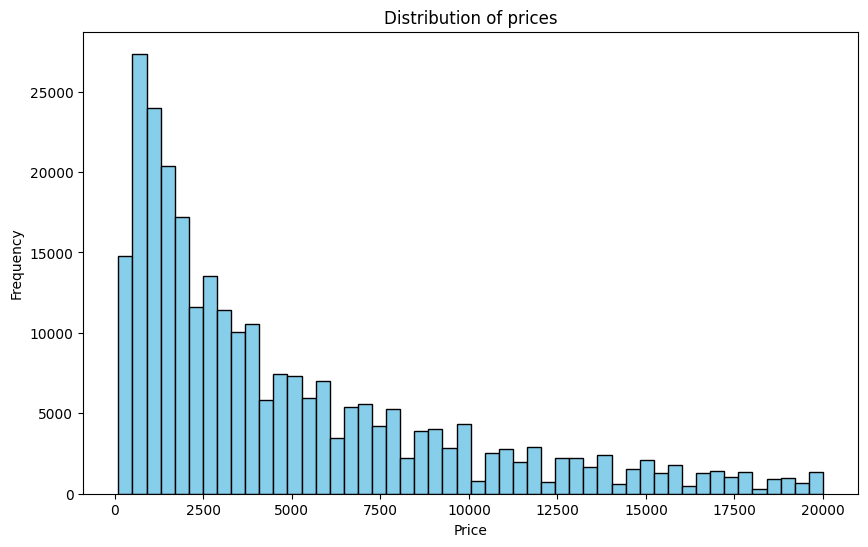

In [25]:
df = df[df['Price'] >= 100]

plt.figure(figsize=(10, 6))

plt.hist(df['Price'], bins=50, color='skyblue', edgecolor='black')

plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of prices')

plt.show()

There is no strong correlation observed between the features and the target. The data is ready for training.

_Summary_:

- After loading the data, the first step was to remove columns that are not informative for future models: DateCrawled, DateCreated, NumberOfPictures, LastSeen. This decision was made because these features are not related to the price of the car, our target variable.

- Four duplicates were removed from the dataset.

- The values "petrol" and "gasoline" in the FuelType column were replaced with "petrol" since they represent the same fuel type.

- In the engine power column, all data above 600 horsepower and below 30 were removed. Approximately 40,000 rows with zero values were replaced with random data ranging from 60 to 200.

- Missing values in the VehicleType and Model columns were replaced based on the relationship between these columns and the Brand column. Empty values in the VehicleType column were replaced similarly to the corresponding filled values in conjunction with Model and Brand. The same approach was applied to the Model column.

- The remaining empty values in the VehicleType and Model columns were removed. Unfortunately, similar replacement in the Gearbox and FuelType columns was not possible because the transmission and fuel type can vary for the same model, affecting the price. Therefore, missing data in these columns was removed.

- Empty values in the Repaired column were filled with random "yes" and "no" values.

- Since Gearbox and Repaired are essentially boolean values, they were replaced with 1 and 0. A manual transmission is represented as 0, and an automatic one as 1. For Repaired, if there was a repair, it is represented as 1, and if not, it is represented as 0.

- In the RegistrationYear column, all values above the year 2016 were removed.

- In the RegistrationMonth column, all zero values were replaced with random values ranging from 1 to 12.

- Correlation check revealed the absence of strong linear dependencies between the target variable and the features.

- All values below 100 euros in the Price column were removed.

## Model Training

To begin with, let's split our data into training (60%), validation (20%), and test (20%) sets.

In [26]:
display(df.head(10))
display(df.tail(10))

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
0,480,small,1993,0,72,golf,150000,4,petrol,volkswagen,0,70435
1,18300,coupe,2011,0,190,tt,125000,5,petrol,audi,1,66954
2,9800,suv,2004,1,163,grand,125000,8,petrol,jeep,0,90480
3,1500,small,2001,0,75,golf,150000,6,petrol,volkswagen,0,91074
4,3600,small,2008,0,69,fabia,90000,7,petrol,skoda,0,60437
5,650,sedan,1995,0,102,3er,150000,10,petrol,bmw,1,33775
6,2200,convertible,2004,0,109,2_reihe,150000,8,petrol,peugeot,0,67112
8,14500,bus,2014,0,125,c_max,30000,8,petrol,ford,0,94505
10,2000,sedan,2004,0,105,3_reihe,150000,12,petrol,mazda,0,96224
11,2799,wagon,2005,0,140,passat,150000,12,petrol,volkswagen,1,57290


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
354353,1999,sedan,1997,0,150,a3,150000,12,petrol,audi,0,4275
354354,5000,sedan,2003,1,260,e_klasse,150000,12,petrol,mercedes_benz,1,90473
354356,999,convertible,2000,0,95,megane,150000,4,petrol,renault,0,88477
354357,1690,wagon,2004,0,55,fabia,150000,4,petrol,skoda,1,18246
354358,1490,small,1998,0,50,lupo,150000,9,petrol,volkswagen,0,48653
354359,7900,sedan,2010,0,140,golf,150000,7,petrol,volkswagen,0,75223
354362,3200,sedan,2004,0,225,leon,150000,5,petrol,seat,1,96465
354366,1199,convertible,2000,1,101,fortwo,125000,3,petrol,smart,0,26135
354367,9200,bus,1996,0,102,transporter,150000,3,petrol,volkswagen,0,87439
354368,3400,wagon,2002,0,100,golf,150000,6,petrol,volkswagen,0,40764


In [27]:
X = df.drop(columns=['Price'])
y = df['Price']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=12345)

X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=12345)

display(f'Train features {X_train.shape}')
display(f'Train target {y_train.shape}')

display(f'Validation features {X_valid.shape}')
display(f'Validation target {y_valid.shape}')

display(f'Test features {X_test.shape}')
display(f'Test target {y_test.shape}')

'Train features (163699, 11)'

'Train target (163699,)'

'Validation features (54567, 11)'

'Validation target (54567,)'

'Test features (54567, 11)'

'Test target (54567,)'

Next, let's bring the data into a common format. Initially, I applied One-Hot Encoding (OHE) to categorical features and scaled numerical features using StandardScaler(). If scaling went smoothly, encoding 4 categorical columns resulted in 299 columns after OHE. The linear regression model took 21 minutes to train the first time and 16 minutes the second time. Training the LightGBM model was not completed. Following the instructor's advice, I attempted to use the preprocessing.TargetEncoder() method from the sklearn library but couldn't import it. Therefore, I loaded the category_encoders library, which also includes TargetEncoder() (the package installation occurs at the beginning of the project before importing all the necessary libraries).

In [28]:
categorical = ['VehicleType', 'Model', 'FuelType', 'Brand']
numeric = ['RegistrationYear', 'Gearbox', 'Power', 'Kilometer', 'RegistrationMonth', 'Repaired', 'PostalCode']

In [29]:
encoder = ce.TargetEncoder()

X_train_categorical = encoder.fit_transform(X_train[categorical], y_train)
X_valid_categorical = encoder.transform(X_valid[categorical])
X_test_categorical = encoder.transform(X_test[categorical])

X_train_categorical = X_train_categorical.reset_index(drop=True)
X_valid_categorical = X_valid_categorical.reset_index(drop=True)
X_test_categorical = X_test_categorical.reset_index(drop=True)

display(f'Train: {X_train_categorical.shape}')
display(f'Validation: {X_valid_categorical.shape}')
display(f'Test: {X_test_categorical.shape}')

'''def ohe_conv(features):
    data_ohe = pd.get_dummies(features[categorical], columns=categorical, drop_first=True)
    data_ohe.reset_index(drop=True, inplace=True)
    return data_ohe

X_train_categorical = ohe_conv(X_train[categorical])
X_valid_categorical = ohe_conv(X_valid[categorical])
X_test_categorical = ohe_conv(X_test[categorical])

display(f'Обучающая: {X_train_categorical.shape}')
display(f'Валидационная: {X_valid_categorical.shape}')
display(f'Тестовая: {X_test_categorical.shape}')'''

'Train: (163699, 4)'

'Validation: (54567, 4)'

'Test: (54567, 4)'

"def ohe_conv(features):\n    data_ohe = pd.get_dummies(features[categorical], columns=categorical, drop_first=True)\n    data_ohe.reset_index(drop=True, inplace=True)\n    return data_ohe\n\nX_train_categorical = ohe_conv(X_train[categorical])\nX_valid_categorical = ohe_conv(X_valid[categorical])\nX_test_categorical = ohe_conv(X_test[categorical])\n\ndisplay(f'Обучающая: {X_train_categorical.shape}')\ndisplay(f'Валидационная: {X_valid_categorical.shape}')\ndisplay(f'Тестовая: {X_test_categorical.shape}')"

In [30]:
display(f'Train: {X_train_categorical.shape}')
display(f'Validation: {X_valid_categorical.shape}')
display(f'Test: {X_test_categorical.shape}')

'Train: (163699, 4)'

'Validation: (54567, 4)'

'Test: (54567, 4)'

In [31]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[numeric])
X_train_numeric = pd.DataFrame(X_train_scaled, columns=numeric)
X_train_numeric.reset_index(drop=True, inplace=True)

def scaler_func (features):
    data_scaled = scaler.transform(features[numeric])
    data_numeric = pd.DataFrame(data_scaled, columns=numeric)
    data_numeric.reset_index(drop=True, inplace=True)
    return data_numeric

X_valid_numeric = scaler_func(X_valid)
X_test_numeric = scaler_func(X_test)

Let's combine categorical and numerical features.

In [32]:
X_train = pd.concat([X_train_numeric, X_train_categorical], axis=1)
X_valid = pd.concat([X_valid_numeric, X_valid_categorical], axis=1)
X_test = pd.concat([X_test_numeric, X_test_categorical], axis=1)

display(f'Train: {X_train.shape}')
display(f'Validation: {X_valid.shape}')
display(f'Test: {X_test.shape}')

display(X_train)

'Train: (163699, 11)'

'Validation: (54567, 11)'

'Test: (54567, 11)'

,RegistrationYear,Gearbox,Power,Kilometer,RegistrationMonth,Repaired,PostalCode,VehicleType,Model,FuelType,Brand
0,-4.395892,-0.501252,-1.483201,-0.785864,1.377429,2.189108,-0.385443,6975.985264,4674.538844,4841.825203,4819.131287
1,-0.911266,-0.501252,-1.179163,0.585204,-0.413285,-0.456807,-1.354113,2806.108226,2860.253333,4841.825203,4819.131287
2,0.514263,-0.501252,-0.324057,0.585204,-1.308642,-0.456807,-0.702399,4917.238456,7162.989691,4841.825203,4413.048263
3,0.831047,1.995005,0.911096,-0.100330,0.482072,-0.456807,-0.016093,4917.238456,5712.914238,4841.825203,6229.512523
4,-0.594482,1.995005,2.811332,0.585204,1.675881,2.189108,-0.134530,4917.238456,6465.565306,4036.748882,6626.152604
...,...,...,...,...,...,...,...,...,...,...,...
163694,-1.069658,1.995005,-0.115031,0.585204,1.078976,-0.456807,-1.736610,4917.238456,5306.217602,4841.825203,6626.152604
163695,0.672655,-0.501252,0.170004,0.585204,1.377429,-0.456807,-0.614483,2806.108226,3994.303709,4841.825203,4413.048263
163696,-0.119306,-0.501252,0.170004,0.585204,0.482072,-0.456807,-1.339726,4917.238456,10428.379915,4841.825203,6146.292597
163697,0.989439,-0.501252,0.341026,-0.100330,-0.413285,-0.456807,0.240016,5077.862512,4692.602698,4841.825203,4819.131287


Also, let's reset the indices in the target datasets.

In [33]:
y_train.reset_index(drop=True, inplace=True)
y_valid.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

display(y_train.shape)
display(y_valid.shape)
display(y_test.shape)

(163699,)

(54567,)

(54567,)

The main quality metric for the model will be RMSE. Let's train several models and choose the best one. We'll consider linear regression, decision tree, random forest, CatBoost, and LightGBM. We will evaluate the best model on the test set.

Linear Regression.

In [34]:
param_grid_lr = {
    'fit_intercept': [True, False]
}

grid_lr = GridSearchCV(LinearRegression(), param_grid_lr, scoring='neg_mean_squared_error', cv=5)

start_time = time.time()
grid_lr.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

start_time = time.time()
y_pred_lr = grid_lr.predict(X_valid)
end_time = time.time()
prediction_time = end_time - start_time
print(f"Prediction time: {prediction_time} seconds")

rmse_lr = (mean_squared_error(y_valid, y_pred_lr))**0.5
print("Linear Regression RMSE:", rmse_lr)

best_params_lr = grid_lr.best_params_
print("Best Linear Regression Hyperparameters:", best_params_lr)

Training time: 0.40830397605895996 seconds
Prediction time: 0.0034182071685791016 seconds
Linear Regression RMSE: 2784.0297860419987
Best Linear Regression Hyperparameters: {'fit_intercept': True}


Decision tree.

In [35]:
param_grid_dt = {
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 4]
}

grid_dt = GridSearchCV(DecisionTreeRegressor(), param_grid_dt, scoring='neg_mean_squared_error', cv=5)
start_time = time.time()
grid_dt.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

start_time = time.time()
y_pred_dt = grid_dt.predict(X_valid)
end_time = time.time()
prediction_time = end_time - start_time
print(f"Prediction time: {prediction_time} seconds")

rmse_dt = (mean_squared_error(y_valid, y_pred_dt))**0.5
print("Decision Tree RMSE:", rmse_lr)

best_params = grid_dt.best_params_
print("Decision Tree best hyperparameters:", best_params)

Training time: 58.64609932899475 seconds
Prediction time: 0.006695985794067383 seconds
Decision Tree RMSE: 2784.0297860419987
Decision Tree best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}


CatBoost

In [36]:
param_grid_cb = {
#    'depth': [6, 8, 10],
#    'learning_rate': [0.1, 0.3, 0.5],
#    'iterations': [100, 200, 300],
    'depth': [10],
    'learning_rate': [0.3],
    'iterations': [300],
}

X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()

catboost_model = CatBoostRegressor()

grid_cb = GridSearchCV(catboost_model, param_grid_cb, scoring='neg_mean_squared_error', cv=5)

start_time = time.time()
grid_cb.fit(X_train_np, y_train_np)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

X_valid_np = X_valid.to_numpy()

start_time = time.time()
y_pred_cb = grid_cb.predict(X_valid_np)
end_time = time.time()
prediction_time = end_time - start_time
print(f"Prediction time: {prediction_time} seconds")

rmse_cb = (mean_squared_error(y_valid, y_pred_cb)) ** 0.5
print("CatBoost RMSE:", rmse_cb)

best_params = grid_cb.best_params_
print("CatBoost best hyperparameters:", best_params)

0:	learn: 3640.1519271	total: 74.8ms	remaining: 22.4s
1:	learn: 2995.1320616	total: 91.7ms	remaining: 13.7s
2:	learn: 2573.2079129	total: 107ms	remaining: 10.6s
3:	learn: 2305.2272083	total: 124ms	remaining: 9.16s
4:	learn: 2126.0329851	total: 139ms	remaining: 8.19s
5:	learn: 2013.6300853	total: 154ms	remaining: 7.57s
6:	learn: 1935.6976530	total: 170ms	remaining: 7.13s
7:	learn: 1886.8027045	total: 186ms	remaining: 6.77s
8:	learn: 1848.3560910	total: 201ms	remaining: 6.5s
9:	learn: 1816.4323499	total: 218ms	remaining: 6.32s
10:	learn: 1796.5346520	total: 235ms	remaining: 6.18s
11:	learn: 1777.6981128	total: 252ms	remaining: 6.04s
12:	learn: 1763.3044955	total: 267ms	remaining: 5.9s
13:	learn: 1749.1378642	total: 284ms	remaining: 5.8s
14:	learn: 1739.5600451	total: 302ms	remaining: 5.74s
15:	learn: 1732.7021959	total: 318ms	remaining: 5.64s
16:	learn: 1723.7307044	total: 334ms	remaining: 5.56s
17:	learn: 1714.3966331	total: 349ms	remaining: 5.47s
18:	learn: 1706.8911600	total: 364ms	re

With the parameters: param_grid_cb = {'depth': [6, 8, 10], 'learning_rate': [0.1, 0.3, 0.5], 'iterations': [100, 200, 300], }

Training time: 1199.4092164039612 seconds

Prediction time: 0.07186055183410645 seconds

CatBoost RMSE: 1717.765216131883

Best hyperparameters: {'depth': 10, 'iterations': 300, 'learning_rate': 0.3}

LightGBM

In [37]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
}

lgb_model = lgb.LGBMRegressor(**params)

param_grid_lgb = {
#    'learning_rate': [0.1, 10],
#    'n_estimators': [10, 30],
    'learning_rate': [0.1],
    'n_estimators': [30],
}

grid_lgb = GridSearchCV(lgb_model, param_grid_lgb, scoring='neg_mean_squared_error', cv=5)

start_time = time.time()
grid_lgb.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time
print(f"LightGBM training time: {training_time} seconds")

start_time = time.time()
y_pred_lgb = grid_lgb.predict(X_valid)
end_time = time.time()
prediction_time = end_time - start_time
print(f"Prediction time LightGBM: {prediction_time} seconds")

rmse_lgb = (mean_squared_error(y_valid, y_pred_lgb))**0.5
print("RMSE LightGBM:", rmse_lgb)

best_params_lgbm = grid_lgb.best_params_
print("LightGBM best hyperparameters:", best_params_lgbm)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 907
[LightGBM] [Info] Number of data points in the train set: 130959, number of used features: 11
[LightGBM] [Info] Start training from score 4829.289381
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 907
[LightGBM] [Info] Number of data points in the train set: 130959, number of used features: 11
[LightGBM] [Info] Start training from score 4835.586428
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

With the parameters: param_grid_lgb = {'learning_rate': [0.1, 10], 'n_estimators': [10, 30], }

LightGBM Training time: 1248.8983018398285 seconds

LightGBM Prediction time: 0.09955191612243652 seconds

LightGBM RMSE: 1923.9797809873703

Best LightGBM Hyperparameters: {'learning_rate': 0.1, 'n_estimators': 30}

Random forest.

In [38]:
param_grid_rf = {
#    'n_estimators': [30, 50, 100],
#    'max_depth': [2, 5, 10],
    'n_estimators': [100],
    'max_depth': [10],
}

grid_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, scoring='neg_mean_squared_error', cv=5)
start_time = time.time()
grid_rf.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time} секунд")

start_time = time.time()
y_pred_rf = grid_rf.predict(X_valid)
end_time = time.time()
prediction_time = end_time - start_time
print(f"Prediction time: {prediction_time} секунд")

rmse_rf = (mean_squared_error(y_valid, y_pred_rf))**0.5
print("Random forest RMSE:", rmse_rf)

best_params_rf = grid_rf.best_params_
print("Random forest best hyperparameters:", best_params_rf)

Training time: 140.76438307762146 секунд
Prediction time: 0.36737608909606934 секунд
Random forest RMSE: 1783.6957976031724
Random forest best hyperparameters: {'max_depth': 10, 'n_estimators': 100}


With the parameters: param_grid_rf = {'n_estimators': [30, 50, 100], 'max_depth': [2, 5, 10], }

Training time for Random Forest: 520.4137606620789 seconds

Prediction time for Random Forest: 0.5314302444458008 seconds

Random Forest RMSE: 1905.7566598043438

Best Random Forest Hyperparameters: {'max_depth': 10, 'n_estimators': 100}

## Model Analysis

After training models using the GridSearchCV method, the following results were obtained:

| Model |Training time sec. | Prediction time sec. | RMSE | Hyperparameters |
-------:|----:|-----:|------:|------:|
| Linear Regression |2 | 0.08 | 2887 | {'fit_intercept': True} |
| Decision Tree |76 | 0.008 | 2024 | {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5} |
| CatBoost | 1199 | 0.07 | 1717 | {'depth': 10, 'iterations': 300, 'learning_rate': 0.3} |
| LightGBM |1248 | 0.09 | 1923 | {'learning_rate': 0.1, 'n_estimators': 30} |
| Random Forest |520 | 0.53 | 1905 | {'max_depth': 10, 'n_estimators': 100} |

_Conclusion_: Preliminarily, it can be noted that gradient boosting models like CatBoost and LightGBM, as well as Random Forest, exhibit the lowest RMSE values.

## Model Testing

Now that the optimal hyperparameters are set for each model, the next step is to test their training time with the specified hyperparameters, prediction time, and prediction quality. Then, we can choose the optimal model based on the customer's requirements. The criteria important to the customer are:

- Prediction quality
- Model training time
- Model prediction time

Linear Regression.

In [39]:
linear_model = LinearRegression(fit_intercept=True)
start_time = time.time()
linear_model.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time

start_time = time.time()
y_pred_linear = linear_model.predict(X_valid)
end_time = time.time()
prediction_time = end_time - start_time

rmse_linear = (mean_squared_error(y_valid, y_pred_linear))**0.5
print(f"Linear Regression - RMSE: {rmse_linear}")
print(f"Training time: {training_time} seconds")
print(f"Prediction time: {prediction_time} seconds")

Linear Regression - RMSE: 2784.0297860419987
Training time: 0.04022502899169922 seconds
Prediction time: 0.002664804458618164 seconds


Decision Tree.

In [40]:
decision_tree_model = DecisionTreeRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=5)
start_time = time.time()
decision_tree_model.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time

start_time = time.time()
y_pred_decision_tree = decision_tree_model.predict(X_valid)
end_time = time.time()
prediction_time = end_time - start_time

rmse_decision_tree = (mean_squared_error(y_valid, y_pred_decision_tree))**0.5
print(f"Decision Tree - RMSE: {rmse_decision_tree}")
print(f"Training time: {training_time} seconds")
print(f"Prediction time: {prediction_time} seconds")

Decision Tree - RMSE: 1895.344080794182
Training time: 0.40923190116882324 seconds
Prediction time: 0.006262063980102539 seconds


CatBoost.

In [41]:
catboost_model = CatBoostRegressor(depth=10, iterations=300, learning_rate=0.3)

X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()

start_time = time.time()
catboost_model.fit(X_train_np, y_train_np)
end_time = time.time()
training_time = end_time - start_time

X_valid_np = X_valid.to_numpy()

start_time = time.time()
y_pred_catboost = catboost_model.predict(X_valid_np)
end_time = time.time()
prediction_time = end_time - start_time

rmse_catboost = (mean_squared_error(y_valid, y_pred_catboost))**0.5
print(f"CatBoost - RMSE: {rmse_catboost}")
print(f"Training time: {training_time} seconds")
print(f"Prediction time: {prediction_time} seconds")

0:	learn: 3641.3051313	total: 21.3ms	remaining: 6.36s
1:	learn: 2984.7385770	total: 42.8ms	remaining: 6.38s
2:	learn: 2554.6375563	total: 62.3ms	remaining: 6.17s
3:	learn: 2278.4477636	total: 82.4ms	remaining: 6.09s
4:	learn: 2101.0968323	total: 103ms	remaining: 6.07s
5:	learn: 1996.4767111	total: 124ms	remaining: 6.07s
6:	learn: 1913.3289596	total: 144ms	remaining: 6.03s
7:	learn: 1867.4810619	total: 165ms	remaining: 6.02s
8:	learn: 1826.2627434	total: 188ms	remaining: 6.08s
9:	learn: 1800.8875261	total: 207ms	remaining: 6.01s
10:	learn: 1779.5069968	total: 226ms	remaining: 5.95s
11:	learn: 1766.0001790	total: 248ms	remaining: 5.96s
12:	learn: 1752.0202010	total: 268ms	remaining: 5.92s
13:	learn: 1742.0141698	total: 287ms	remaining: 5.86s
14:	learn: 1733.0728090	total: 305ms	remaining: 5.8s
15:	learn: 1725.1377697	total: 325ms	remaining: 5.76s
16:	learn: 1719.4274846	total: 344ms	remaining: 5.72s
17:	learn: 1707.9840031	total: 363ms	remaining: 5.69s
18:	learn: 1702.1374043	total: 383m

LigthGBM.

In [42]:
lgbm_model = lgb.LGBMRegressor(learning_rate=0.3, n_estimators=70, max_depth=10, num_leaves=30)
start_time = time.time()
lgbm_model.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time

start_time = time.time()
y_pred_lgbm = lgbm_model.predict(X_valid)
end_time = time.time()
prediction_time = end_time - start_time

rmse_lgbm = (mean_squared_error(y_valid, y_pred_lgbm))**0.5
print(f"LightGBM - RMSE: {rmse_lgbm}")
print(f"Training time: {training_time} seconds")
print(f"Prediction time: {prediction_time} seconds")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 914
[LightGBM] [Info] Number of data points in the train set: 163699, number of used features: 11
[LightGBM] [Info] Start training from score 4831.586332
LightGBM - RMSE: 1637.074379759445
Training time: 0.26967906951904297 seconds
Prediction time: 0.06473207473754883 seconds


Random Forest.

In [43]:
random_forest_model = RandomForestRegressor(max_depth=10, n_estimators=100)
start_time = time.time()
random_forest_model.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time

start_time = time.time()
y_pred_random_forest = random_forest_model.predict(X_valid)
end_time = time.time()
prediction_time = end_time - start_time

rmse_random_forest = (mean_squared_error(y_valid, y_pred_random_forest))**0.5
print(f"Random Forest - RMSE: {rmse_random_forest}")
print(f"Training time: {training_time} seconds")
print(f"Prediction time: {prediction_time} seconds")

Random Forest - RMSE: 1783.9860731788278
Training time: 28.492663145065308 seconds
Prediction time: 0.3616490364074707 seconds


Let's choose the optimal model based on the testing results:

| Model |Training time sec. | Prediction time sec. | RMSE | Hyperparameters |
-------:|----:|-----:|------:|------:|
| Linear Regression |0.03 | 0.04 | 2786 | {'fit_intercept': True} |
| Decision Tree |0.7 | 0.008 | 1907 | {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5} |
| CatBoost | 19 | 0.07 | 1579 | {'depth': 10, 'iterations': 300, 'learning_rate': 0.3} |
| LightGBM | 167 | 0.31 | 1629 | {learning_rate:0.3, n_estimators:70, max_depth:10, num_leaves:30} |
| Random Forest | 36.8 | 0.5 | 1787 | {'max_depth': 10, 'n_estimators': 100} |

From the table, it's evident that CatBoost and LightGBM are the most accurate models, but CatBoost achieves similar prediction accuracy in less time.

Conclusion: The CatBoost gradient boosting model demonstrated both speed and accuracy among all models. With approximately similar hyperparameters, CatBoost requires less time for both training (17 seconds) and prediction (0.06 seconds), while LightGBM takes more time for training (38 seconds) and prediction (0.3 seconds). Additionally, CatBoost exhibits higher accuracy based on the RMSE metric. Considering all the factors mentioned, the CatBoost model is recommended for deployment.

Let's now evaluate the CatBoost model on the test dataset.

In [44]:
catboost_model = CatBoostRegressor(depth=10, iterations=300, learning_rate=0.3)

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

start_time = time.time()
catboost_model.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time

X_test = X_test.to_numpy()

start_time = time.time()
y_pred_catboost = catboost_model.predict(X_test)
end_time = time.time()
prediction_time = end_time - start_time

rmse_catboost = (mean_squared_error(y_test, y_pred_catboost))**0.5
print(f"CatBoost - RMSE: {rmse_catboost}")
print(f"Training time: {training_time} seconds")
print(f"Prediction time: {prediction_time} seconds")

0:	learn: 3641.3051313	total: 18.8ms	remaining: 5.62s
1:	learn: 2984.7385770	total: 39.5ms	remaining: 5.88s
2:	learn: 2554.6375563	total: 58.5ms	remaining: 5.79s
3:	learn: 2278.4477636	total: 78.3ms	remaining: 5.8s
4:	learn: 2101.0968323	total: 98.1ms	remaining: 5.79s
5:	learn: 1996.4767111	total: 117ms	remaining: 5.75s
6:	learn: 1913.3289596	total: 137ms	remaining: 5.71s
7:	learn: 1867.4810619	total: 156ms	remaining: 5.7s
8:	learn: 1826.2627434	total: 176ms	remaining: 5.68s
9:	learn: 1800.8875261	total: 196ms	remaining: 5.69s
10:	learn: 1779.5069968	total: 216ms	remaining: 5.67s
11:	learn: 1766.0001790	total: 235ms	remaining: 5.64s
12:	learn: 1752.0202010	total: 257ms	remaining: 5.67s
13:	learn: 1742.0141698	total: 276ms	remaining: 5.64s
14:	learn: 1733.0728090	total: 295ms	remaining: 5.61s
15:	learn: 1725.1377697	total: 315ms	remaining: 5.58s
16:	learn: 1719.4274846	total: 333ms	remaining: 5.55s
17:	learn: 1707.9840031	total: 353ms	remaining: 5.53s
18:	learn: 1702.1374043	total: 373m

_Conclusion_: The CatBoost model performed well during the prediction check on the test dataset. The RMSE value remained nearly unchanged, indicating that the model's accuracy remained consistent. The training and prediction speeds also remained high.

## GENERAL CONCLUSION:

_IMPORTANT! The category_encoders library was loaded for future encoding of categorical features._

- After loading the data, columns that are not informative for future models were removed: DateCrawled, DateCreated, NumberOfPictures, LastSeen. The reason is that these features are not related to the price of the car, our target variable.

- Four duplicates were removed from the data.

- Values petrol and gasoline in the FuelType column were replaced with petrol because they represent the same thing.

- In the column with engine power, all data above 600 horsepower and below 30 were removed. Zero values, around 40,000 rows, were replaced with random data from 60 to 200.

- Missing values in the VehicleType and Model columns, due to the connection between these columns and the Brand column, were replaced analogously. That is, empty values in the VehicleType column were replaced with analogous ones filled in conjunction with Model and Brand. The same was done for the Model column.

- The remaining empty values in the VehicleType and Model columns were removed. Unfortunately, it was not possible to replace missing data in the Gearbox and FuelType columns in a similar way because the gearbox and fuel type can vary for the same model. For example, diesel or petrol, automatic or manual gearbox. This usually directly affects the price. Therefore, missing data was removed.

- Empty values in the Repaired column were filled with random values yes and no.

- Since Gearbox and Repaired are essentially boolean values, they were replaced with 1 and 0. Manual gearbox - 0, automatic - 1. Whether there was a repair: yes - 1, no - 0.

- In the RegistrationYear column, all values above the year 2016 were removed.

- In the RegistrationMonth column, all zero values were replaced with random values from 1 to 12.

- The correlation check showed the absence of strong linear dependencies between the target variable and the features.

- During the data split into training (60%), validation (20%), and test (20%) sets, the data was further encoded using the StandardScaler() method for numerical features.

- Categorical data was encoded using the TargetEncoder method from the category_encoders library. Since after encoding categorical features with the OHE method, 4 columns were transformed into 299, significantly slowing down model training (for example, the linear regression model took more than 20 minutes to train).

- During the training and validation check, CatBoost performed the best with the hyperparameters - {'depth': 10, 'iterations': 300, 'learning_rate': 0.3} - RMSE: 1699.336424734914, Training time: 17 seconds, Prediction time: 0.06 seconds.

__Based on the customer's requirements for accuracy, training time, and prediction time, the CatBoost model showed the best results among all models used in this project. Therefore, it is recommended for further implementation.__